# CNN Regression Model

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Sample

<AxesSubplot:title={'center':'Velocity'}>

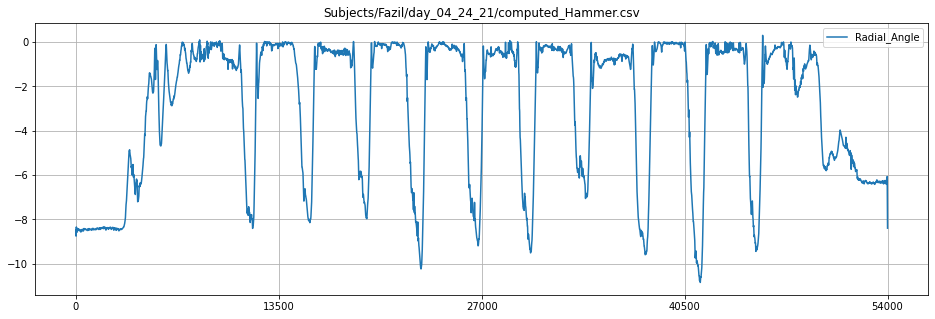

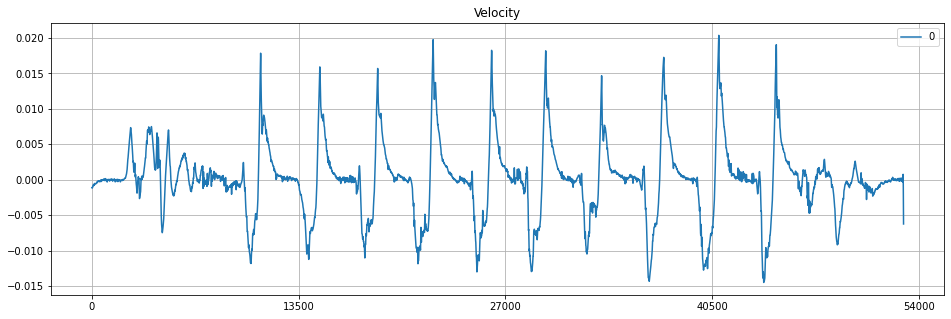

In [2]:
file = 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Radial_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

arr = np.diff([0]+list(df['Radial_Angle']))
# arr = arr/df.index
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr[1000:]).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))

## Prep Data

In [3]:
window = 400

In [4]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files = files[:2]+files[4:]
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup02.csv',
 'Subjec

In [5]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [6]:
files_df = filter_df(files_df)

In [7]:
X, y = multiple_prep_data_velocity(files_df,window,interval=10,Normalize=False,rms=False,angle_label ='Radial_Angle')
X.shape

(136920, 400, 8)

## Time Window Normalize

In [8]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std_radial',np.array([X_mean,X_std]))

In [9]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(109536, 400, 8)
(27384, 400, 8)
(109536, 1)
(27384, 1)


# Neural Network Regression

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [12]:
n_outputs = 1
in_shape = (X.shape[1],X.shape[2])

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(10,activation='relu'))
model.add(Dense(n_outputs))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 398, 64)           1600      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 64)           12352     
_________________________________________________________________
dropout (Dropout)            (None, 396, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 394, 64)           12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 392, 8)            1544      
_________________________________________________________________
dropout_1 (Dropout)          (None, 392, 8)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [13]:
cnn_history=model.fit(X_train,y_train,epochs = 25,batch_size = 4000,validation_data = (X_test,y_test) )

Epoch 1/25
28/28 [==============================] - 13s 345ms/step - loss: 1.0233 - val_loss: 0.9937
Epoch 2/25
28/28 [==============================] - 8s 294ms/step - loss: 0.9896 - val_loss: 0.9747
Epoch 3/25
28/28 [==============================] - 8s 300ms/step - loss: 0.9738 - val_loss: 0.9536
Epoch 4/25
28/28 [==============================] - 8s 297ms/step - loss: 0.9512 - val_loss: 0.9261
Epoch 5/25
28/28 [==============================] - 8s 299ms/step - loss: 0.9246 - val_loss: 0.9027
Epoch 6/25
28/28 [==============================] - 8s 299ms/step - loss: 0.9046 - val_loss: 0.8855
Epoch 7/25
28/28 [==============================] - 9s 304ms/step - loss: 0.8799 - val_loss: 0.8456
Epoch 8/25
28/28 [==============================] - 9s 318ms/step - loss: 0.8538 - val_loss: 0.8343
Epoch 9/25
28/28 [==============================] - 9s 324ms/step - loss: 0.8368 - val_loss: 0.7963
Epoch 10/25
28/28 [==============================] - 9s 340ms/step - loss: 0.8170 - val_loss: 0.778

In [14]:
model.save('models/radial_velocity_model_{}.hdf5'.format(window))

In [15]:
import matplotlib.pyplot as plt
def plot_model(history):
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['root_mean_squared_error'][1:])
#     plt.plot(history.history['val_root_mean_squared_error'][1:])
#     plt.title('Model RMSE',size=20)
#     plt.ylabel('RMSE Loss',size=15)
#     plt.xlabel('Epochs', size=15)
#     plt.legend(['Training', 'Testing'], loc='best')
#     plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()

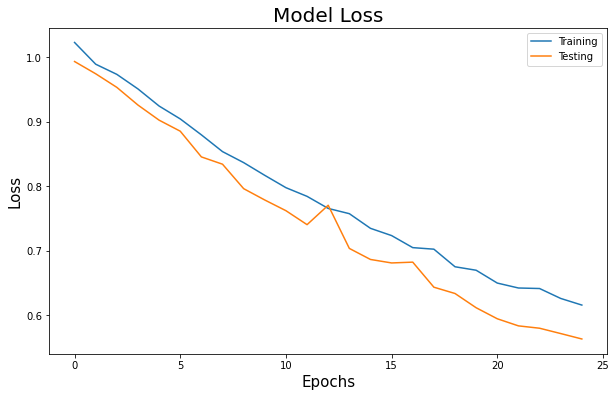

In [16]:
plot_model(cnn_history)

In [3]:
model = load_model('models/radial_velocity_model_{}.hdf5'.format(window))

NameError: name 'window' is not defined

## Model Testing

In [17]:
window = 400
model = load_model('models/radial_velocity_model_{}.hdf5'.format(400))

In [18]:
file = 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv'
df = pd.read_csv(file,index_col=0)

In [19]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=False,rms=False,angle_label ='Radial_Angle')

In [21]:
X_mean = np.load('mean_std_radial.npy')[0]
X_std = np.load('mean_std_radial.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

In [22]:
pred = model.predict(X)

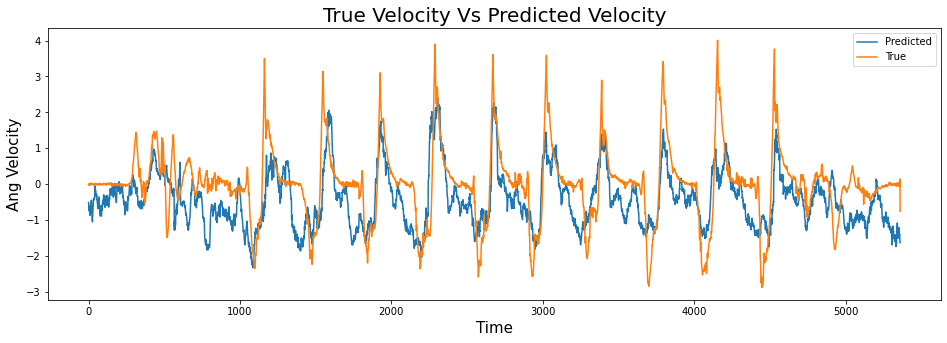

In [23]:
plt.figure(figsize=(16,5))
plt.plot(pred)
plt.plot(y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity',size=15)
plt.xlabel('Time', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [24]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE Loss -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))

MSE Loss - 0.7938324101288748
RMSE Loss - 0.890972732539484
Pearson Correlation Coefficient - (0.6480404160521716, 0.0)
